### Pair: MOREIRA Luiz Fernando & SANGINETO Marina

# Graph Learning
## Lab 4: Hierarchical Clustering

In this lab, you will learn to analyse the hierarchical structure of a graph.

## Import

In [1]:
from IPython.display import SVG

In [2]:
import numpy as np
from scipy import sparse

In [3]:
from sknetwork.data import load_netset, karate_club
from sknetwork.hierarchy import LouvainIteration, Paris, cut_straight
from sknetwork.ranking import PageRank, top_k
from sknetwork.visualization import visualize_graph, visualize_dendrogram
from sknetwork.clustering import aggregate_graph
from sknetwork.utils import get_membership, get_weights
from sknetwork.linalg import normalize

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paristech.fr/) collection for details):
* Openflights (graph)
* WikiVitals (directed graph)

In [4]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')

Parsing files...
Done.
Parsing files...
Done.


## 1. Graphs

## Karate Club


We first consider the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club), a small graph with ground-truth clusters.

In [5]:
dataset = karate_club(True)

In [6]:
adjacency = dataset.adjacency
position = dataset.position
labels_true = dataset.labels

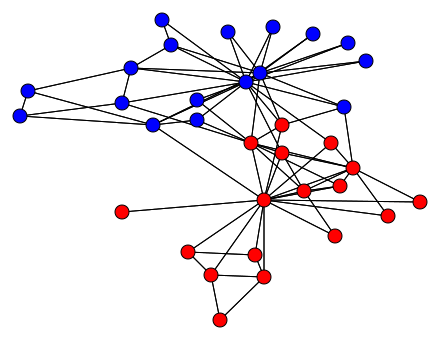

In [7]:
image = visualize_graph(adjacency, position, labels=labels_true)
SVG(image)

## To do

* Cluster the graph by the hierarchical Louvain algorithm (divisive algorithm, top-down).
* Display the dendrogram.
* How many clusters are there at depth 1?
* Display the graph with the corresponding clustering.
* How many clusters are there at depth 2?

**Answers**:
* How many clusters are there at depth 1? There are 4 clusters at depth 1 as we can better visualize through the dendogram bellow.
* How many clusters are there at depth 2? There are 9 clusters at depth 2.

In [8]:
louvain = LouvainIteration()

In [9]:
dendrogram = louvain.fit_predict(adjacency)

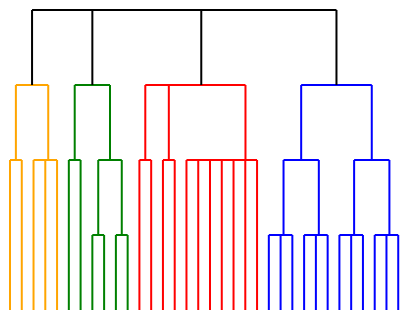

In [10]:
image = visualize_dendrogram(dendrogram)
SVG(image)

In [11]:
# find a clustering with n_clusters (at least n_clusters, if there is no cut with n_clusters)
labels = cut_straight(dendrogram, n_clusters=2)

In [12]:
print(len(set(labels)))

4


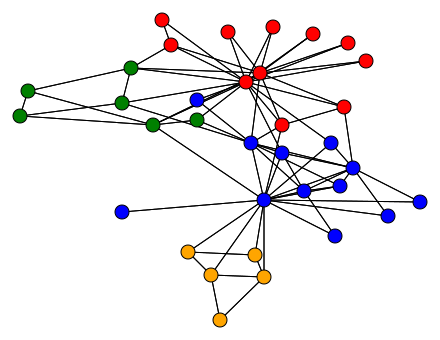

In [13]:
image = visualize_graph(adjacency, position, labels=labels)
SVG(image)

## To do

* Cluster the graph by the Paris algorithm.
* Display the dendrogram.
* Display the graph with the top-2 clusters. Compare this clustering to the ground-truth labels.
* Display the graph with the top-4 clusters. Compare this clustering with that given by Louvain (depth 1).
* Display the corresponding aggregate dendrogram (check the parameters of the function ``cut_straight``).

In [14]:
paris = Paris()

In [15]:
dendrogram = paris.fit_predict(adjacency)

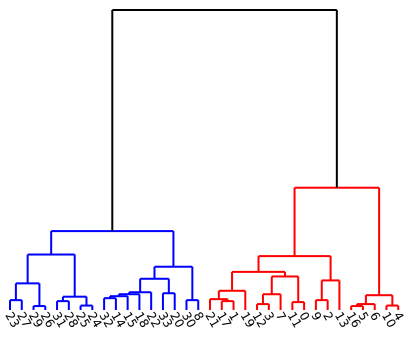

In [16]:
image = visualize_dendrogram(dendrogram, names=np.arange(34))
SVG(image)

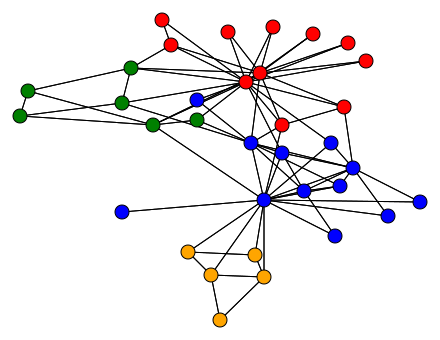

In [17]:
# display the graph with the top 2 clusters
labels_2_clusters = cut_straight(dendrogram, n_clusters=2)
image = visualize_graph(adjacency, position, labels=labels)
SVG(image)

In [18]:
# compare with the ground-truth
print(sum((labels_2_clusters != labels_true)))

2


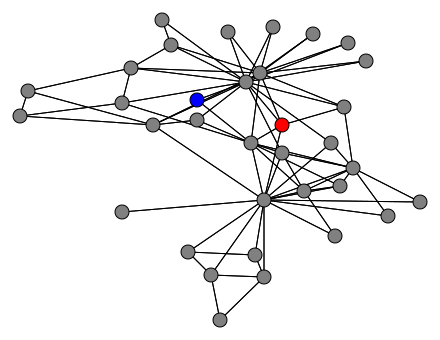

In [19]:
image = visualize_graph(adjacency, position, labels={i: labels[i] for i in np.flatnonzero(labels_2_clusters != labels_true)})
SVG(image)

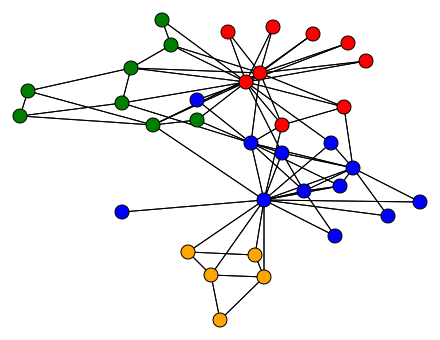

In [20]:
# display the graph with the top 4 clusters
labels, dendrogram_aggregate = cut_straight(dendrogram, n_clusters=4, return_dendrogram=True)
image = visualize_graph(adjacency, position, labels=labels)
SVG(image)

In [21]:
# compare with the louvain one
louvain_dendrogram = louvain.fit_predict(adjacency)
louvain_labels = cut_straight(louvain_dendrogram, n_clusters=2)

print(sum((labels != louvain_labels)))

2


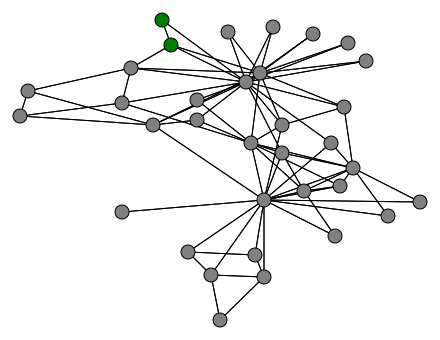

In [22]:
image = visualize_graph(adjacency, position, labels={i: labels[i] for i in np.flatnonzero(labels != louvain_labels)})
SVG(image)

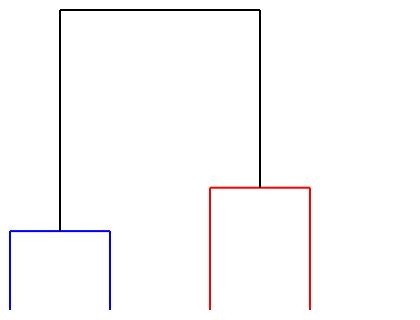

In [23]:
# display aggregate dendrogram
image = visualize_dendrogram(dendrogram_aggregate)
SVG(image)

## Openflights


In [24]:
dataset = openflights

In [25]:
adjacency = dataset.adjacency
position = dataset.position
names = dataset.names

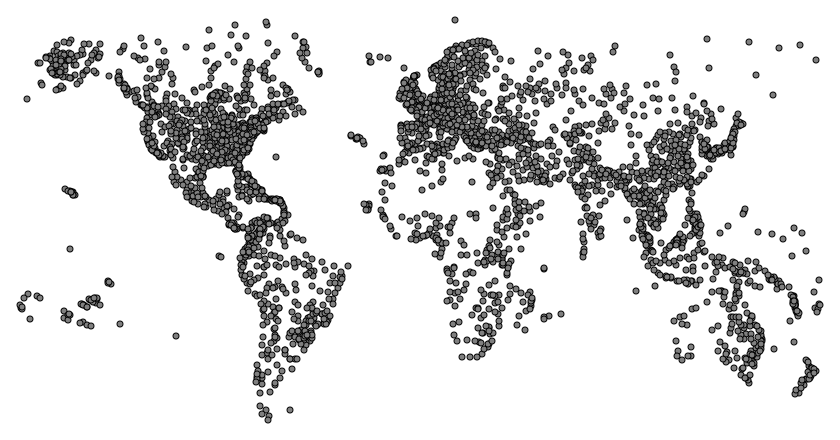

In [26]:
image = visualize_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the same world map with the top-10 clusters found by Paris.<br>
Refer to the [tutorial on Louvain](https://scikit-network.readthedocs.io/en/latest/tutorials/clustering/louvain.html) to display the aggregate graph.
* Display the aggregate dendrogram formed by the top-40 clusters found by Paris, with the name of the top airport  (in traffic) of each cluster. <br>Check the parameters of the function ``visualize_dendrogram`` for better visualization.

In [27]:
# Fit with Paris algorithm
paris = Paris()
dendrogram = paris.fit_predict(adjacency)

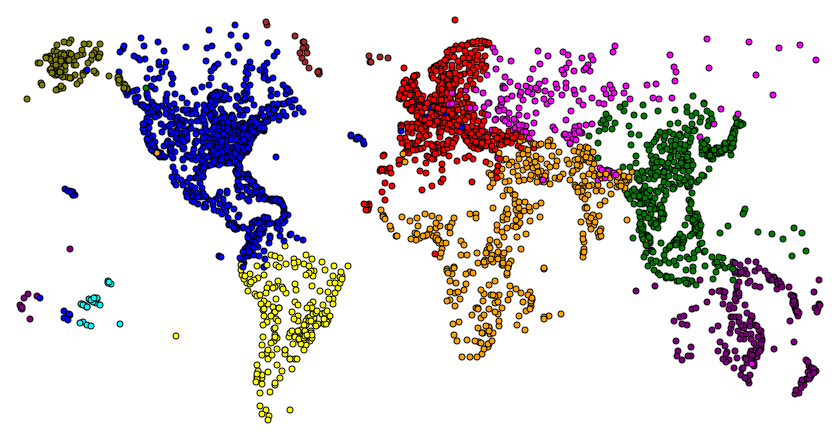

In [28]:
# get 10 clusters
labels = cut_straight(dendrogram, n_clusters=10)

# display the graph with 10 clusters
image = visualize_graph(adjacency, position, width=800, height=400, node_size=3, labels=labels, display_edges=False)
SVG(image)

In [29]:
# aggregate graph of clusters
adjacency_agg = aggregate_graph(adjacency, labels)
labels_unique, counts = np.unique(labels, return_counts=True)
membership = get_membership(labels)
average = normalize(membership.T)  # normalize rows to sum to 1
position_agg = average.dot(position) # weighted average of original positions


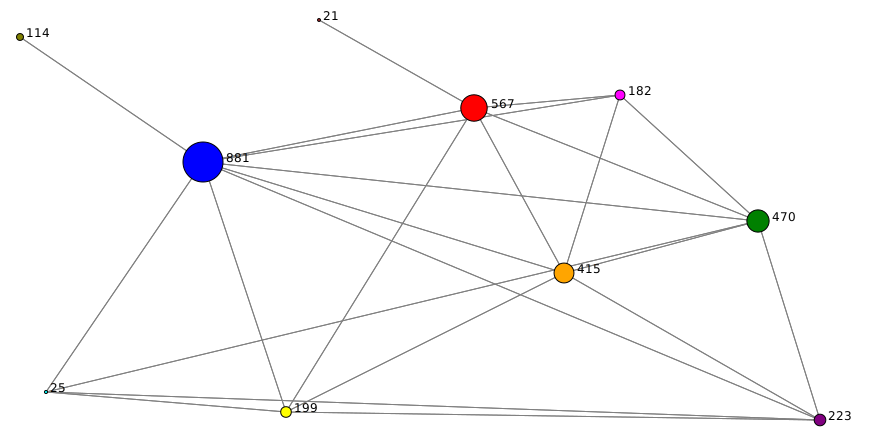

In [30]:
image = visualize_graph(
    adjacency_agg,
    position_agg,
    counts,                 # node_weights
    labels=labels_unique,
    display_node_weight=True,
    node_weights=counts,
    width=800,
    height=400)

SVG(image)

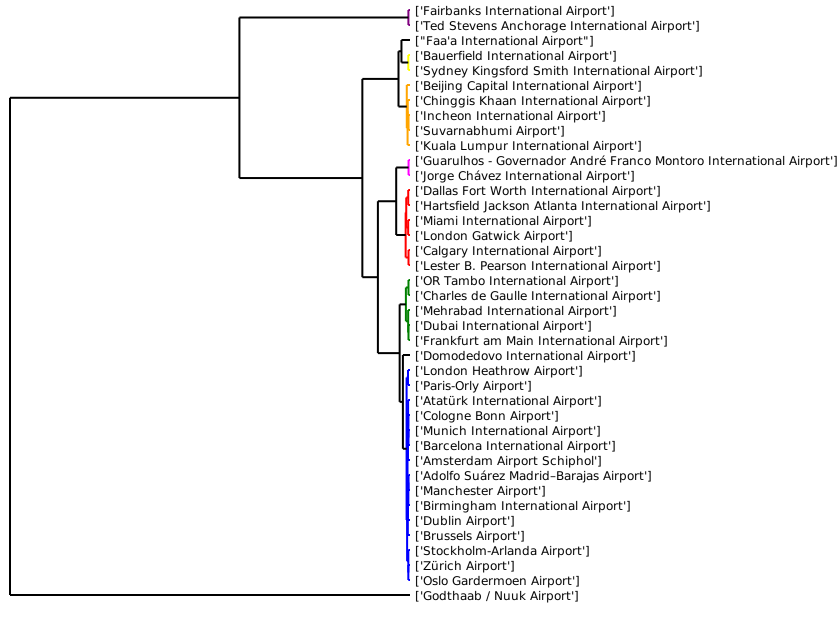

In [31]:
# full dendrogram into 40 clusters and get the aggregate dendrogram

labels_40, dendrogram_agg = cut_straight(dendrogram, n_clusters=40, return_dendrogram=True)

# Compute a traffic score for each airport: sum of edge-weights = # of routes
traffic = adjacency.sum(axis=1).A1

# For each cluster, pick the node with highest traffic
top_indices = []
for c in range(40):
    members = np.where(labels_40 == c)[0]
    top_idx = members[top_k(traffic[members])]
    top_indices.append(top_idx)
top_names = names[top_indices]

# Visualize the aggregate dendrogram, labeling leaves by top airport name

image = visualize_dendrogram(
    dendrogram_agg,
    names=top_names,
    n_clusters=10,
    rotate=True,
    height=600
)
SVG(image)

## 2. Directed graphs

## Wikipedia Vitals

In [32]:
dataset = wikivitals

In [33]:
adjacency = dataset.adjacency
names = dataset.names

## To do

* Cluster the graph by the Paris algorithm.
* Give the size and top-5 articles (in terms of Personalized PageRank) of each of the top-40 clusters found by Paris.
* Display the aggregate dendrogram formed by the top-40 clusters, with the name of the top article of each cluster. Comment the results.

## Answer:

In the displayed aggregate dendrogram we can see that articles belonging to the same topic—such as countries or quantitative sciences—are closer to each other, while different topics form distinct aggregate clusters.

Moreover, clusters represented by the same name, such as Geographic coordinate system, Taxonomy, and The New York Times, tends to be positioned very close together.

Another remark is that “United States” appears multiple times, indicating its overall relevance.



In [34]:
paris = Paris()
dendrogram = paris.fit_predict(adjacency)

In [35]:
labels, dendrogram_agg = cut_straight(dendrogram, n_clusters=40, return_dendrogram=True)
pagerank = PageRank()

In [36]:
top_articles = []
for c in range(40):
  mask = labels == c
  score = pagerank.fit_predict(adjacency, weights=mask)
  top_articles_c = top_k(score, k=5)
  top_articles.append(names[top_articles_c][0])
  print(f"Cluster {c} has {mask.sum()} items")
  print(f"Top 5 articles: {names[top_articles_c]}")
  print('')

Cluster 0 has 726 items
Top 5 articles: ['The New York Times' 'World War II' 'United States' 'BBC'
 'Time (magazine)']

Cluster 1 has 674 items
Top 5 articles: ['Taxonomy (biology)' 'Animal' 'Chordate' 'Permian' 'Jurassic']

Cluster 2 has 604 items
Top 5 articles: ['Taxonomy (biology)' 'Plant' 'Flowering plant' 'Protein' 'United States']

Cluster 3 has 478 items
Top 5 articles: ['Latin' 'United States' 'World Health Organization' 'Medical diagnosis'
 'World War II']

Cluster 4 has 427 items
Top 5 articles: ['United States' 'Geographic coordinate system' 'Water' 'Earth'
 'World War II']

Cluster 5 has 329 items
Top 5 articles: ['Albert Einstein' 'Physics' 'International System of Units' 'Electron'
 'Kelvin']

Cluster 6 has 318 items
Top 5 articles: ['Christianity' 'Catholic Church' 'Eastern Orthodox Church' 'Judaism'
 'Augustine of Hippo']

Cluster 7 has 317 items
Top 5 articles: ['Oxygen' 'Hydrogen' 'Carbon' 'Nitrogen' 'Iron']

Cluster 8 has 293 items
Top 5 articles: ['Immanuel Kant' '

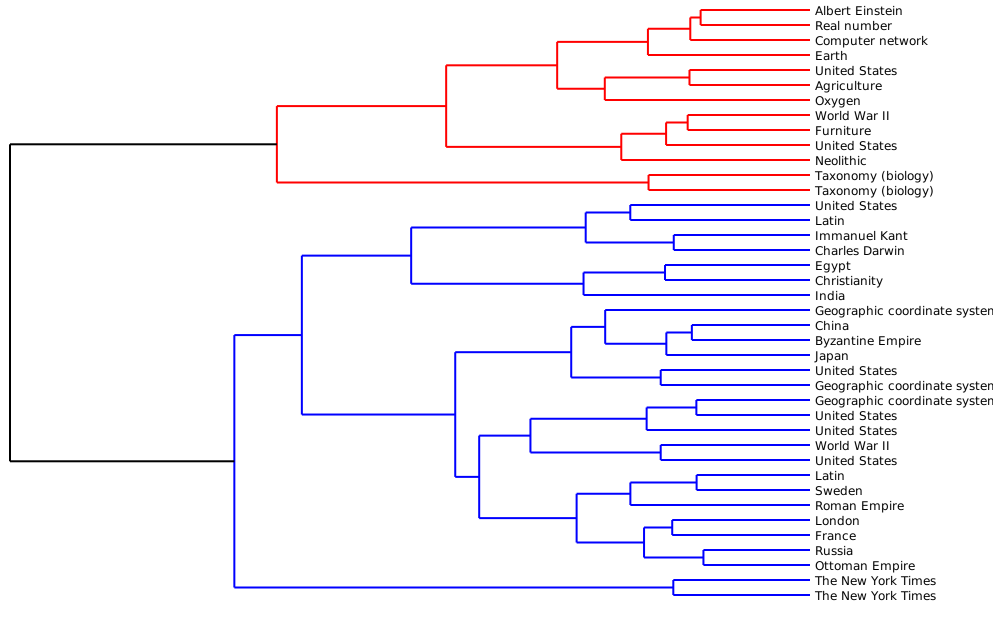

In [37]:
image = visualize_dendrogram(dendrogram_agg, names=top_articles, rotate=True, scale=2)
SVG(image)

## To do

* Complete the following function that returns the nested clusters from a target node in a dendrogram.
* Give the size and top-5 articles of each nested cluster from the article **Riverboat**.
* Do the same with another article of your choice.

In [38]:
def get_nested_clusters(dendrogram: np.ndarray, node: int):
    '''Get the nested clusters of a node, following the path from the corresponding leaf to the root in the dendrogram.

    Parameters
    ----------
    dendrogram:
        Dendrogram
    node:
        Target node

    Returns
    -------
    cluster_nested: list of list
        Nested clusters, as a partition of the set of nodes
        (the k-th nested cluster is the concatenation of the first k lists).

    Example
    -------
    >>> dendrogram = np.array([[0, 1, 1, 2], [2, 3, 1, 2], [4, 5, 1, 4]])
    >>> get_nested_clusters(dendrogram, 0)
    [[0], [1], [2, 3]]
    '''
    n = dendrogram.shape[0] + 1

    cluster = {i: [i] for i in range(n)}
    nested_clusters = [[node]]
    cluster_index = node

    for t in range(n - 1):
        i = int(dendrogram[t][0])
        j = int(dendrogram[t][1])

        new_id = n + t

        cluster[new_id] = cluster[i] + cluster[j]

        if cluster_index == i:
            sibling = j
        elif cluster_index == j:
            sibling = i
        else:
            continue

        nested_clusters.append(cluster[sibling])

        cluster_index = new_id

    return nested_clusters

In [39]:
{i: name for i, name in enumerate(names) if name=='Riverboat'}

{7696: np.str_('Riverboat')}

In [40]:
names[7696]

np.str_('Riverboat')

In [41]:
nested_cluster = get_nested_clusters(dendrogram, node = 7696)

In [42]:
top_5 = []
clusters = []
for c in nested_cluster:
  clusters += c
  weights = {node: 1 for node in clusters}
  score = pagerank.fit_predict(adjacency, weights=weights)
  top_articles = top_k(score, k=5)
  top_5.append(names[top_articles[0]][0])
  print(f"Cluster {names[c][0]} has {len(c)} items")
  print(f"Top 5 articles: {names[top_articles]}")
  print('')

Cluster Riverboat has 1 items
Top 5 articles: ['Riverboat' 'United States' 'Barge' 'Ferry' 'Japan']

Cluster Tanker (ship) has 1 items
Top 5 articles: ['Tanker (ship)' 'Riverboat' 'Ferry' 'Barge' 'Fishing vessel']

Cluster Passenger ship has 2 items
Top 5 articles: ['Tanker (ship)' 'Riverboat' 'Passenger ship' 'Merchant ship' 'Ferry']

Cluster Freight transport has 1 items
Top 5 articles: ['Tanker (ship)' 'Riverboat' 'Passenger ship' 'Merchant ship'
 'Freight transport']

Cluster Cargo ship has 1 items
Top 5 articles: ['Tanker (ship)' 'Riverboat' 'Passenger ship' 'Cargo ship' 'Merchant ship']

Cluster Fishing vessel has 1 items
Top 5 articles: ['Fishing vessel' 'Tanker (ship)' 'Riverboat' 'Passenger ship'
 'Cargo ship']

Cluster Barge has 1 items
Top 5 articles: ['Fishing vessel' 'Barge' 'Tanker (ship)' 'Riverboat' 'Passenger ship']

Cluster Ferry has 1 items
Top 5 articles: ['Ferry' 'Fishing vessel' 'Barge' 'Tanker (ship)' 'Riverboat']

Cluster Ship has 1 items
Top 5 articles: ['Ferry

In [43]:
print(names[42])
nested_cluster = get_nested_clusters(dendrogram, node = 42)

Abel Tasman


In [44]:
top_5 = []
clusters = []
for c in nested_cluster:
  clusters += c
  weights = {node: 1 for node in clusters}
  score = pagerank.fit_predict(adjacency, weights=weights)
  top_articles = top_k(score, k=5)
  top_5.append(names[top_articles[0]][0])
  print(f"Cluster {names[c][0]} has {len(c)} items")
  print(f"Top 5 articles: {names[top_articles]}")
  print('')

Cluster Abel Tasman has 1 items
Top 5 articles: ['Abel Tasman' 'Dutch East India Company' 'New Guinea' 'Thailand'
 'James Cook']

Cluster Southern Alps / Kā Tiritiri o te Moana has 1 items
Top 5 articles: ['Abel Tasman' 'Southern Alps / Kā Tiritiri o te Moana' 'South Island'
 'Geographic coordinate system' 'Glacier']

Cluster Cook Strait has 1 items
Top 5 articles: ['Abel Tasman' 'Cook Strait' 'Southern Alps / Kā Tiritiri o te Moana'
 'Geographic coordinate system' 'South Island']

Cluster Johannes Vermeer has 4 items
Top 5 articles: ['Abel Tasman' 'Willem Barentsz' 'Johannes Vermeer' 'Atlas'
 'Mercator projection']

Cluster Novaya Zemlya has 2 items
Top 5 articles: ['Abel Tasman' 'Willem Barentsz' 'Northeast Passage' 'Johannes Vermeer'
 'Atlas']

Cluster Svalbard has 1 items
Top 5 articles: ['Abel Tasman' 'Willem Barentsz' 'Northeast Passage' 'Johannes Vermeer'
 'Atlas']

Cluster Dutch East India Company has 1 items
Top 5 articles: ['Abel Tasman' 'Dutch East India Company' 'Willem Bar